In [20]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from data import CleanedData
from models import nn
import sklearn.metrics
import torch
import sklearn.metrics

# For Adaboost
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data imputing, cleaning and feature extraction

In [21]:
data = CleanedData(loc='./data/joined.csv.gz', test_ratio=0.2, impute_data=True, convert_non_numerical=True, normalize_data=True, drop_columns=['source', 'Last_Update','province','country','latitude', 'longitude'])

/opt/miniconda3/envs/cmpt353/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


## Splitting data to test and training data

In [22]:
X_train, y_train = data.training_data
X_test, y_test = data.test_data

In [23]:
X_train.head(5)

,age,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incidence_Rate,Case-Fatality_Ratio,confirmed_day,in_contact,transformed_Combined_Key,transformed_sex
411601,20.000000,11.006091,78.400624,13.182344,9.069353,13.072578,10.747337,6.525087,1.635877,150.0,0.0,439.0,0.0
447906,39.665537,14.705180,76.166436,13.128310,8.962904,12.884172,11.524340,6.612669,1.552342,131.0,0.0,217.0,2.0
340255,38.960609,26.583423,73.847973,11.619895,7.176255,11.432420,9.782280,4.922457,1.175308,151.0,0.0,374.0,2.0
487351,24.500000,50.833300,4.469936,11.520378,9.204725,9.849295,11.182461,6.767683,9.870171,88.0,0.0,51.0,1.0
269932,44.479524,28.646519,77.108980,12.383499,8.498418,12.214393,10.381273,7.151806,2.054617,104.0,0.0,116.0,2.0


## Model 1 variations, neural network with different hyperparameters and architectures

In [24]:
# Loading up the neural netowrk models
models = []
for i in range(4):
    if i < 2:
        models.append(nn.network_1())
    else:
        models.append(nn.network_2())
    nn.load_model(models[i], f'model_{i+1}.pth')

## Accuracy of each model on training and validation data

In [25]:
for i in range(4):
    print(f'training accuracy of model_{i+1}: {nn.eval(models[i], X_train, y_train):.2f}%')
    print(f'validation accuracy of model_{i+1}: {nn.eval(models[i], X_test, y_test):.2f}%')

training accuracy of model_1: 81.36%
validation accuracy of model_1: 81.34%
training accuracy of model_2: 79.80%
validation accuracy of model_2: 79.71%
training accuracy of model_3: 80.48%
validation accuracy of model_3: 80.39%
training accuracy of model_4: 81.40%
validation accuracy of model_4: 81.33%


## Making predictions

In [26]:
models_training_preds = []
models_validation_preds = []
for i in range(4):
    models_training_preds.append(torch.argmax(torch.softmax(models[i](torch.tensor(X_train.values).float()), dim=1), dim=1))
    models_validation_preds.append(torch.argmax(torch.softmax(models[i](torch.tensor(X_test.values).float()), dim=1), dim=1))

## F-2 scores of different models only on the training dataset

In [27]:
for i in range(4):
    print(f'F_2 score of model {i+1} on training dataset: {sklearn.metrics.fbeta_score(y_train, models_training_preds[i], beta=2, average="macro"):.4f}')
    print(f'F_2 score of model {i+1} on validation dataset: {sklearn.metrics.fbeta_score(y_test, models_validation_preds[i], beta=2, average="macro"):.4f}')

F_2 score of model 1 on training dataset: 0.5489
F_2 score of model 1 on validation dataset: 0.5502
F_2 score of model 2 on training dataset: 0.5210
F_2 score of model 2 on validation dataset: 0.5204
F_2 score of model 3 on training dataset: 0.5352
F_2 score of model 3 on validation dataset: 0.5352
F_2 score of model 4 on training dataset: 0.5023
F_2 score of model 4 on validation dataset: 0.5036


In [28]:
sklearn.metrics.fbeta_score(y_test, models_validation_preds[i], beta=2, average=None)

array([0.0127426 , 0.89317578, 0.98888413, 0.11960362])

In [29]:
data.encoder.classes_.tolist()

['deceased', 'hospitalized', 'nonhospitalized', 'recovered']

## Confusion matrices for the best performing model

In [30]:
conf_matrix_train = sklearn.metrics.confusion_matrix(y_train.values, models_training_preds[3])
conf_matrix_val = sklearn.metrics.confusion_matrix(y_test.values, models_validation_preds[3])

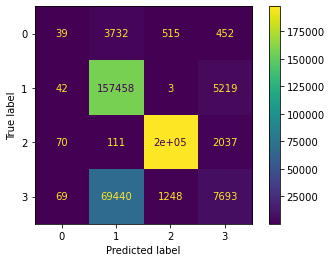

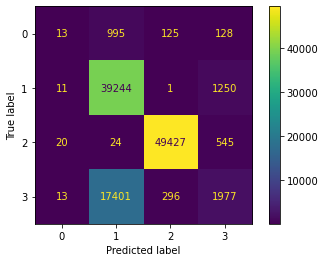

In [31]:
sklearn.metrics.ConfusionMatrixDisplay(conf_matrix_train).plot()
sklearn.metrics.ConfusionMatrixDisplay(conf_matrix_val).plot()

## Model 2: Adaboost

In [32]:
adaboost = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 20),n_estimators = 25, learning_rate = 1)
with open('./data/adaboost_model.pkl', 'rb') as f:
    adaboost = pickle.load(f)

### Training Set Accuracy Score

In [33]:
adaboost.score(X_train,y_train)

0.8122001708983827

### Test set Accuracy Score

In [34]:
adaboost.score(X_test,y_test)

0.8118417511438055

### Confusion Matrices

#### Test Data Set

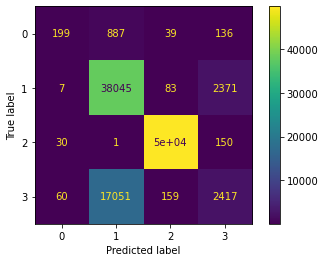

In [35]:
y_test_pred = adaboost.predict(X_test)
test_matrix = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(test_matrix).plot()

#### Training Data Set

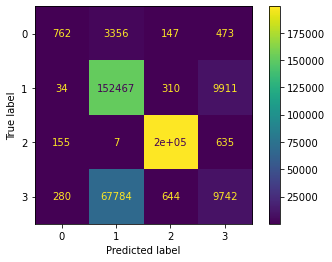

In [36]:
y_train_pred = adaboost.predict(X_train)
train_matrix = confusion_matrix(y_train, y_train_pred)
ConfusionMatrixDisplay(train_matrix).plot()

####  F-2 Scores

In [38]:
print(f'F_2 score of Adaboost on training dataset: {sklearn.metrics.fbeta_score(y_train, y_train_pred, beta=2, average="macro"):.4f}')
print(f'F_2 score of Adaboost on validation dataset: {sklearn.metrics.fbeta_score(y_test, y_test_pred, beta=2, average="macro"):.4f}')

F_2 score of Adaboost on training dataset: 0.5505
F_2 score of Adaboost on validation dataset: 0.5498


In [39]:
sklearn.metrics.fbeta_score(y_test, y_test_pred, beta=2, average=None)

array([0.18632959, 0.87255972, 0.99598289, 0.14417456])